INBUILT INTERVENTION IN THE LANGGRAPH 

In [47]:
from langchain_groq import ChatGroq
from langgraph.graph import START,StateGraph,END
from typing import Annotated
from typing import TypedDict
from IPython.display import display,Image
from langgraph.graph.message import add_messages
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode,tools_condition
from langchain.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver

In [48]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [49]:
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [50]:
llm=ChatGroq(model="gemma2-9b-it")

In [51]:
llm.invoke("what is gen ai")

AIMessage(content='"Gen AI" is short for **Generative Artificial Intelligence**. \n\nIt\'s a type of artificial intelligence that focuses on **creating new content**, rather than simply analyzing existing data. \n\nThink of it like this:\n\n* **Traditional AI:** Analyzes data to find patterns and make predictions (e.g., recommending products you might like).\n* **Gen AI:** Uses learned patterns to generate new content (e.g., writing a poem, composing music, creating an image).\n\nHere are some key things to know about Gen AI:\n\n**How it works:**\n\nGen AI models are trained on massive datasets of text, code, images, audio, etc. This allows them to learn the underlying patterns and structures of that data. Then, they can use this knowledge to generate new content that resembles the training data.\n\n**Examples:**\n\n* **Text Generation:** ChatGPT, Bard, Jasper are examples of Gen AI models that can write stories, articles, poems, and even code.\n* **Image Generation:** DALL-E 2, Stable

In [52]:
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

In [53]:
search=TavilySearchResults()

In [54]:
search.invoke("which team won the 2011 cricket world cup")

[{'url': 'https://wcwinners.com/icc-winners/icc-wc-2011/',
  'content': 'India won the tournament, defeating Sri Lanka by six wickets in the final at Wankidi Stadium in Mumbai, thus becoming the first country to win a Cricket World Cup Final on home soil. Pakistan loses its status as host In April 2009, the International Criminal Court announced that Pakistan had lost its right to co-host the 2011 World Cup due to concerns about the “uncertain security situation” in the country, particularly in the wake of the 2009 attack on Sri Lanka’s national cricket team in Lahore. ICC Men’s T20 Cricket World Cup 2021 Winners List and Runners-Up Awards™ ICC World Cup 2015 Final History | ICC Cricket World Cup 2015 Winner And Runner UP List And info ICC Men’s Cricket World Cup 2019 Winners List and Runners-Up'},
 {'url': 'https://www.livemint.com/sports/cricket-news/icc-world-cup-winner-history-2011',
  'content': 'News India News World News Business News/Sports/Cricket-News/ \xa0\xa0ICC World Cup H

In [55]:
tools=[search]

In [56]:
llm_with_tool=llm.bind_tools(tools=tools)

In [57]:
tool_node=ToolNode(tools=tools)

In [58]:
class AgentState(TypedDict):
    messages:Annotated[list,add_messages]

In [59]:
def function_1(state:AgentState):
    print("==> entering into the llm <==")
    response=llm_with_tool.invoke(state["messages"])
    return {"messages":[response]}

In [60]:
graph=StateGraph(AgentState)

In [61]:
graph.add_node("llm",function_1)
graph.add_node("tools",tool_node)
graph.set_entry_point("llm")

graph.add_conditional_edges(
    "llm",
    tools_condition
)

graph.add_edge("tools","llm")

In [62]:
memory=MemorySaver()

In [63]:
app=graph.compile(
    checkpointer=memory,
    interrupt_before=["tools"])

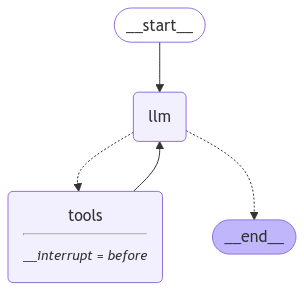

In [64]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except  Exception as e:
    print(e)

In [65]:
config={"configurable":{"thread_id":1}}

In [66]:
events=app.stream({"messages":["which team won the 2011 cricket world cup"]},config=config,stream_mode='values')

In [67]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

which team won the 2011 cricket world cup
==> entering into the llm <==
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_tv72)
 Call ID: call_tv72
  Args:
    query: which team won the 2011 cricket world cup


In [68]:
snapshot=app.get_state(config)

In [69]:
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='which team won the 2011 cricket world cup', additional_kwargs={}, response_metadata={}, id='1f2ec3e0-bcbc-4013-b605-cb67c844342d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tv72', 'function': {'arguments': '{"query":"which team won the 2011 cricket world cup"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 98, 'prompt_tokens': 993, 'total_tokens': 1091, 'completion_time': 0.178181818, 'prompt_time': 0.054813331, 'queue_time': 0.019686321, 'total_time': 0.232995149}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f76593d2-667c-45ea-a99d-477a0c488774-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'which team won the 2011 cricket world cup'}, 'id': 'call_tv72', 'type': 'tool_call'}], usage_metadata={'input_tokens': 993, 'output_t

In [70]:
snapshot.next

('tools',)

In [71]:
last_message=snapshot.values['messages'][-1]

In [72]:
last_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tv72', 'function': {'arguments': '{"query":"which team won the 2011 cricket world cup"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 98, 'prompt_tokens': 993, 'total_tokens': 1091, 'completion_time': 0.178181818, 'prompt_time': 0.054813331, 'queue_time': 0.019686321, 'total_time': 0.232995149}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f76593d2-667c-45ea-a99d-477a0c488774-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'which team won the 2011 cricket world cup'}, 'id': 'call_tv72', 'type': 'tool_call'}], usage_metadata={'input_tokens': 993, 'output_tokens': 98, 'total_tokens': 1091})

In [73]:
last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'which team won the 2011 cricket world cup'},
  'id': 'call_tv72',
  'type': 'tool_call'}]

In [74]:
events=app.stream(None,config=config,stream_mode='values')

In [75]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_tv72)
 Call ID: call_tv72
  Args:
    query: which team won the 2011 cricket world cup
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.hindustantimes.com/cricket/world-cup/history-winner-2011", "content": "News News/ Cricket/ World Cup/ World Cup 2011 History and Winner India would host and win the 2011 World Cup with MS Dhoni famously finishing it off, before Australia would make it 5 at home in 2015, and England finally won by beating New Zealand in a tied game and then a tied super-over. The 2011 Cricket World Cup, hosted jointly by India, Sri Lanka, and Bangladesh, marked a significant moment in Indian cricket history. India would host and win the 2011 World Cup with MS Dhoni famously finishing it off, before Australia would make it 5 at home in 2015, and England final

In [76]:
events=app.stream({"messages":["what is the captain name"]},config=config,stream_mode='values')

In [77]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what is the captain name
==> entering into the llm <==
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_2fxy)
 Call ID: call_2fxy
  Args:
    query: who was the captain of india in the 2011 cricket world cup


In [78]:
snapshot=app.get_state(config)

In [79]:
snapshot.next

('tools',)

In [80]:
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='which team won the 2011 cricket world cup', additional_kwargs={}, response_metadata={}, id='1f2ec3e0-bcbc-4013-b605-cb67c844342d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tv72', 'function': {'arguments': '{"query":"which team won the 2011 cricket world cup"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 98, 'prompt_tokens': 993, 'total_tokens': 1091, 'completion_time': 0.178181818, 'prompt_time': 0.054813331, 'queue_time': 0.019686321, 'total_time': 0.232995149}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f76593d2-667c-45ea-a99d-477a0c488774-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'which team won the 2011 cricket world cup'}, 'id': 'call_tv72', 'type': 'tool_call'}], usage_metadata={'input_tokens': 993, 'output_t

In [81]:
last_message=snapshot.values['messages'][-1]

In [82]:
last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'who was the captain of india in the 2011 cricket world cup'},
  'id': 'call_2fxy',
  'type': 'tool_call'}]

In [83]:
events=app.stream(None,config=config,stream_mode='values')

In [84]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_2fxy)
 Call ID: call_2fxy
  Args:
    query: who was the captain of india in the 2011 cricket world cup
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.winzogames.com/blog/2011-world-cup-indian-team/", "content": "The 2011 Cricket ODI World Cup, hosted by India, Sri Lanka, and Bangladesh, marked the 10th edition of the tournament and featured 14 nations competing for glory. ... 2011 World Cup India Squad. Mahendra Singh Dhoni (Captain), Virender Sehwag (Vice Captain), Sachin Tendulkar, Gautam Gambhir, Virat Kohli, Yuvraj Singh, Suresh Raina, Yusuf Pathan"}, {"url": "https://swagcricket.com/2011-world-cup-team-captains-where-are-they-now/", "content": "2011 World Cup team captains - Where are they now? Facebook Instagram Twitter 2011 World Cup team captains – Where are they

how to give the custom data into llm

In [85]:
events=app.stream({"messages":["how many runs he scored in that match "]},config=config,stream_mode='values')

In [86]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

how many runs he scored in that match 
==> entering into the llm <==
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_m5jc)
 Call ID: call_m5jc
  Args:
    query: how many runs did ms dhoni score in the 2011 cricket world cup final


In [87]:
from langchain_core.messages import ToolMessage,AIMessage

In [89]:
snapshot=app.get_state(config)

In [90]:
snapshot.next

('tools',)

In [91]:
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='which team won the 2011 cricket world cup', additional_kwargs={}, response_metadata={}, id='1f2ec3e0-bcbc-4013-b605-cb67c844342d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tv72', 'function': {'arguments': '{"query":"which team won the 2011 cricket world cup"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 98, 'prompt_tokens': 993, 'total_tokens': 1091, 'completion_time': 0.178181818, 'prompt_time': 0.054813331, 'queue_time': 0.019686321, 'total_time': 0.232995149}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f76593d2-667c-45ea-a99d-477a0c488774-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'which team won the 2011 cricket world cup'}, 'id': 'call_tv72', 'type': 'tool_call'}], usage_metadata={'input_tokens': 993, 'output_t

In [92]:
last_message=snapshot.values["messages"][-1]

In [93]:
last_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_m5jc', 'function': {'arguments': '{"query":"how many runs did ms dhoni score in the 2011 cricket world cup final"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 4339, 'total_tokens': 4407, 'completion_time': 0.123636364, 'prompt_time': 0.143970545, 'queue_time': 0.039521055, 'total_time': 0.267606909}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c5db39fb-5bb8-4435-b388-2652636849ca-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'how many runs did ms dhoni score in the 2011 cricket world cup final'}, 'id': 'call_m5jc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 4339, 'output_tokens': 68, 'total_tokens': 4407})

In [97]:
id=last_message.tool_calls[0]["id"]

In [88]:
answer="He scored 91 runs in the final againt srilankans"

In [101]:
new_message=[ToolMessage(content=answer,tool_call_id=id),
             AIMessage(content=answer)]

In [102]:
app.update_state(
    config,
    {"messages":new_message}
)

{'configurable': {'thread_id': 1,
  'checkpoint_ns': '',
  'checkpoint_id': '1efce112-ba19-6501-800d-321ff94a8f5e'}}

In [103]:
print(app.get_state(config=config).values["messages"][-1:])

[AIMessage(content='He scored 91 runs in the final againt srilankans', additional_kwargs={}, response_metadata={}, id='2fccde35-b1a0-45f5-9b79-82080697be47')]
